<a href="https://colab.research.google.com/github/OlleThomsen/annda_lab_1b/blob/main/assignment_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

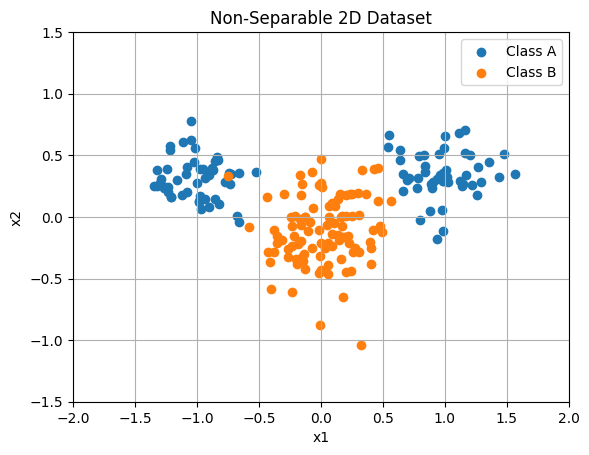

In [2]:
ndata = 100
mA = np.array([1.0, 0.3])
sigmaA = 0.2
mB = np.array([0.0, -0.1])
sigmaB = 0.3

classA_1 = np.concatenate([
    np.random.randn(ndata // 2) * sigmaA - mA[0],
    np.random.randn(ndata // 2) * sigmaA + mA[0]
])
classA_2 = np.random.randn(ndata) * sigmaA + mA[1]

classA = np.vstack([classA_1, classA_2])

classB_1 = np.random.randn(ndata) * sigmaB + mB[0]
classB_2 = np.random.randn(ndata) * sigmaB + mB[1]

classB = np.vstack([classB_1, classB_2])

X = np.hstack([classA, classB])

T_delta = np.hstack([-np.ones(ndata), np.ones(ndata)])
T_perc = np.hstack([np.zeros(ndata), np.ones(ndata)])

perm = np.random.permutation(2 * ndata)
X = X[:, perm]
T_perc = T_perc[perm]
T_delta = T_delta[perm]

plt.figure()
plt.scatter(X[0, T_delta == -1], X[1, T_delta == -1], label="Class A")
plt.scatter(X[0, T_delta == 1], X[1, T_delta == 1], label="Class B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-2, 2)
plt.ylim(-1.5, 1.5)
plt.title(f"Non-Separable 2D Dataset")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
class BackPropagation:
    def __init__(self, n_input, n_hidden, n_output, eta=0.01, alpha=0.9):
        self.eta = eta
        self.alpha = alpha
        self.n_hidden = n_hidden

        self.W = np.random.normal(0, 0.1, (n_hidden, n_input + 1))
        self.V = np.random.normal(0, 0.1, (n_output, n_hidden + 1))

        self.dw = np.zeros(self.W.shape)
        self.dv = np.zeros(self.V.shape)

    def _phi(self, x):
        return (2 / (1 + np.exp(-x))) - 1

    def _phi_prime(self, out):
        return 0.5 * (1 + out) * (1 - out)

    def train(self, X, T, epochs, mse_debug=False):
        n_data = X.shape[1]

        X_with_bias = np.vstack([X, np.ones((1, n_data))])

        for epoch in range(epochs):
            # Forward Pass
            hin = self.W @ X_with_bias
            hout_raw = self._phi(hin)

            hout = np.vstack([hout_raw, np.ones((1, n_data))])

            oin = self.V @ hout
            out = self._phi(oin)

            # Backward Pass
            delta_o = (out - T) * self._phi_prime(out)

            delta_h_raw = (self.V.T @ delta_o) * self._phi_prime(hout)
            delta_h = delta_h_raw[:self.n_hidden, :]

            # Update hidden-to-output weights (V)
            self.dv = (self.alpha * self.dv) - (1 - self.alpha) * (delta_o @ hout.T)
            self.V += self.dv * self.eta

            # Update input-to-hidden weights (W)
            self.dw = (self.alpha * self.dw) - (1 - self.alpha) * (delta_h @ X_with_bias.T)
            self.W += self.dw * self.eta

            mse = np.mean(np.square(out - T))

            if epoch % 100 == 0 and mse_debug:
                print(f"Epoch {epoch}: MSE = {mse:.6f}")

        print(f"number of hidden nodes = {self.n_hidden}")
        print(f"Final MSE = {mse}")
        acc = self.accuracy(X, T)
        print(f"Final Accuracy = {acc}%\n")

    def train_with_validation(self, X_train, T_train, X_val, T_val, epochs, mse_debug=False):
      n_train = X_train.shape[1]
      n_val = X_val.shape[1]

      X_train_bias = np.vstack([X_train, np.ones((1, n_train))])
      X_val_bias = np.vstack([X_val, np.ones((1, n_val))])

      self.history = {
          'mse_train': [],
          'mse_val': []
      }

      for epoch in range(epochs):
          # Training forward pass
          hin = self.W @ X_train_bias
          hout_raw = self._phi(hin)
          hout = np.vstack([hout_raw, np.ones((1, n_train))])
          oin = self.V @ hout
          out = self._phi(oin)

          # validation forward pass without backprop
          v_hin = self.W @ X_val_bias
          v_hout = np.vstack([self._phi(v_hin), np.ones((1, n_val))])
          v_out = self._phi(self.V @ v_hout)

          # training backwards pass
          delta_o = (out - T_train) * self._phi_prime(out)
          delta_h_raw = (self.V.T @ delta_o) * self._phi_prime(hout)
          delta_h = delta_h_raw[:self.n_hidden, :]

          # Update weights
          self.dv = (self.alpha * self.dv) - (1 - self.alpha) * (delta_o @ hout.T)
          self.V += self.dv * self.eta

          self.dw = (self.alpha * self.dw) - (1 - self.alpha) * (delta_h @ X_train_bias.T)
          self.W += self.dw * self.eta

          mse_train = np.mean(np.square(out - T_train))
          mse_val = np.mean(np.square(v_out - T_val))

          self.history['mse_train'].append(mse_train)
          self.history['mse_val'].append(mse_val)

          if epoch % 100 == 0 and mse_debug:
              print(f"Epoch {epoch}: Train MSE = {mse_train:.6f} | Val MSE = {mse_val:.6f}")

      print(f"Number of hidden nodes = {self.n_hidden}")
      print(f"Final Train MSE: {self.history['mse_train'][-1]:.6f}")
      print(f"Final Val MSE: {self.history['mse_val'][-1]:.6f}")

      train_acc = self.accuracy(X_train, T_train)
      val_acc = self.accuracy(X_val, T_val)
      print(f"Final Train Accuracy = {train_acc:.6f}%")
      print(f"Final Val Accuracy = {val_acc:.6f}%\n")

      return self.history


    def accuracy(self, X, T):
        out = self.predict(X)
        preds = np.where(out >= 0, 1, -1)

        correct_hits = np.sum(preds == T)
        acc = (correct_hits / T.size) * 100
        return acc

    def predict(self, X):
        n_data = X.shape[1]
        X_with_bias = np.vstack([X, np.ones((1, n_data))])

        hout_raw = self._phi(self.W @ X_with_bias)
        hout = np.vstack([hout_raw, np.ones((1, n_data))])
        return self._phi(self.V @ hout)

In [7]:
for n in range(1, 15):
  nn = BackPropagation(n_input=2, n_hidden=n, n_output=1, eta=0.1, alpha=0.9)
  nn.train(X, T_delta, epochs=5000)

number of hidden nodes = 1
Final MSE = 0.454521284088853
Final Accuracy = 85.0%

number of hidden nodes = 2
Final MSE = 0.020125832333364117
Final Accuracy = 99.5%

number of hidden nodes = 3
Final MSE = 0.020101173103379905
Final Accuracy = 99.5%

number of hidden nodes = 4
Final MSE = 0.020097153636935226
Final Accuracy = 99.5%

number of hidden nodes = 5
Final MSE = 0.020104507007006996
Final Accuracy = 99.5%

number of hidden nodes = 6
Final MSE = 0.020100767654656525
Final Accuracy = 99.5%

number of hidden nodes = 7
Final MSE = 0.020105825838698962
Final Accuracy = 99.5%

number of hidden nodes = 8
Final MSE = 0.020095502157764785
Final Accuracy = 99.5%

number of hidden nodes = 9
Final MSE = 0.02009554599230014
Final Accuracy = 99.5%

number of hidden nodes = 10
Final MSE = 0.020101779005571422
Final Accuracy = 99.5%

number of hidden nodes = 11
Final MSE = 0.020104795760095506
Final Accuracy = 99.5%

number of hidden nodes = 12
Final MSE = 0.02008807914795251
Final Accuracy = 9

In [8]:
import numpy as np

def apply_sampling_scenario(X, T_delta, scenario):

    idx_A = np.where(T_delta == -1)[0]
    idx_B = np.where(T_delta == 1)[0]

    train_idx_A = []
    train_idx_B = []

    match scenario:
        case 1:
            train_idx_A = np.random.choice(idx_A, size=int(0.25 * len(idx_A)), replace=False)
            train_idx_B = np.random.choice(idx_B, size=int(0.25 * len(idx_B)), replace=False)

        case 2:
            train_idx_A = np.random.choice(idx_A, size=int(0.50 * len(idx_A)), replace=False)
            train_idx_B = idx_B

        case 3:
            mask_neg = (X[0, idx_A] < 0)
            mask_pos = (X[0, idx_A] >= 0)

            sub_idx_neg = idx_A[mask_neg]
            sub_idx_pos = idx_A[mask_pos]

            keep_neg = np.random.choice(sub_idx_neg, size=int(0.2 * len(sub_idx_neg)), replace=False)
            keep_pos = np.random.choice(sub_idx_pos, size=int(0.8 * len(sub_idx_pos)), replace=False)

            train_idx_A = np.concatenate([keep_neg, keep_pos])
            train_idx_B = idx_B

    train_indices = np.concatenate([train_idx_A, train_idx_B])

    all_indices = np.arange(X.shape[1])
    val_indices = np.setdiff1d(all_indices, train_indices)

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    X_train, T_train = X[:, train_indices], T_delta[train_indices]
    X_val, T_val = X[:, val_indices], T_delta[val_indices]

    return X_train, T_train, X_val, T_val

Number of hidden nodes = 5
Final Train MSE: 0.000883
Final Val MSE: 0.385845
Final Train Accuracy = 100.000000%
Final Val Accuracy = 90.000000%



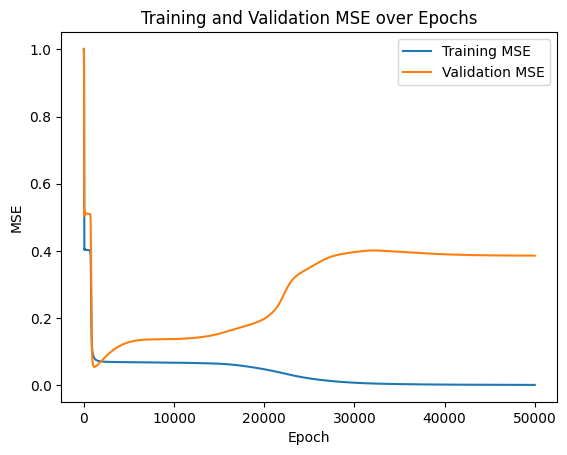

In [55]:
X_train, T_train, X_val, T_val = apply_sampling_scenario(X, T_delta, scenario=1)
nn = BackPropagation(n_input=2, n_hidden=5, n_output=1, eta=0.05, alpha=0.9)
history = nn.train_with_validation(X_train, T_train, X_val, T_val, epochs=50000)

plt.figure()
plt.plot(history['mse_train'], label='Training MSE')
plt.plot(history['mse_val'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE over Epochs')
plt.legend()
plt.show()